# Disciplina Aprendizado Profundo

### Prof. Josenalde Barbosa - IMD/UFRN

### Aluno: Bruno Santos F. Silva

#### Objetivo: elaborar um classificador usando redes neurais profundas LSTM e pytorch com a finalidade de identificar processos judiciais que serão deferidos, indeferidos ou deferidos parcialmente.

Obs. Atividade avaliativa final da disciplina.

## 1. Importação de Bibliotecas Essenciais

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
import warnings
import time
from collections import Counter
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
from sklearn.preprocessing import LabelEncoder

# Métricas e avaliação
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# Configurações
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configurar device (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")

print(f"✓ PyTorch versão: {torch.__version__}")
print(f"✓ NumPy versão: {np.__version__}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...


✓ Device: cuda
✓ GPU: Tesla T4
✓ CUDA Version: 12.6
✓ PyTorch versão: 2.9.0+cu126
✓ NumPy versão: 2.0.2


[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Carregar e Gerar Dataset

Carregando/Gerando dataset com 160,000 amostras...
⚠ Erro ao carregar SQLite: unable to open database file
Gerando dataset sintético com 160,000 amostras...

✓ Dataset sintético gerado: (160000, 4)

ANÁLISE EXPLORATÓRIA DO DATASET

Primeiras amostras:
                                       texto_peticao               desfecho  \
0  Apelação em conformidade com os prazos legalme...             Indeferida   
1  Procedimento ordinário com todas as fases proc...               Deferida   
2  Documentação completa e direito inequívoco jus...               Deferida   
3  Fundamentado em jurisprudência consolidada, so...             Indeferida   
4  Parte do pleito merece acolhimento, com modula...             Indeferida   
5  Carência de legitimidade ativa e passiva inval...             Indeferida   
6  Apelação em conformidade com os prazos legalme...             Indeferida   
7  Prescrição consumada extingue o direito de açã...  Parcialmente_Deferida   
8  Competência originária da Corte Su

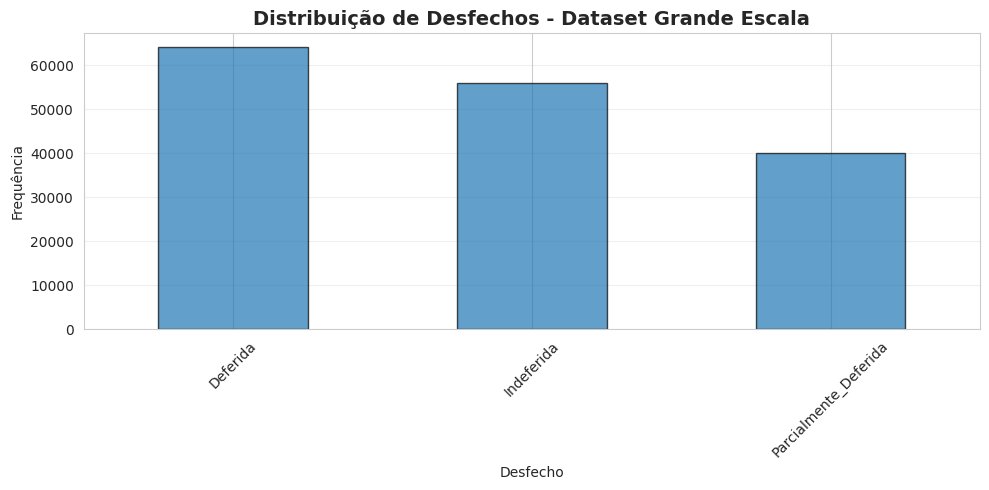

In [2]:
# Parâmetros
DB_PATH = "/gdrive/MyDrive/Colab Notebooks/JFRN/split_dados_01.sqlite3"
TABLE_NAME = "peticoes"
DATASET_SIZE = 160000

print(f"Carregando/Gerando dataset com {DATASET_SIZE:,} amostras...")

# Tentar carregar do SQLite
try:
    conn = sqlite3.connect(DB_PATH)
    query = f"SELECT * FROM {TABLE_NAME} LIMIT {DATASET_SIZE}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"✓ Dados carregados do SQLite: {df.shape}")
except Exception as e:
    print(f"⚠ Erro ao carregar SQLite: {e}")
    print(f"Gerando dataset sintético com {DATASET_SIZE:,} amostras...\n")

    # Corpus variado de petições jurídicas
    corpus_templates = [
        # Petições deferidas (linguagem favorável)
        "Fundamentado em jurisprudência consolidada, solicita-se deferimento integral do pedido",
        "Documentação completa e direito inequívoco justificam a concessão pleiteada",
        "Precedentes do STJ e STF amplaram o reconhecimento desta modalidade de direito",
        "Ampla documentação apresentada comprova inequivocamente o direito invocado",
        "Recurso extraordinário com repercussão geral reconhecida sobre matéria já pacificada",

        # Petições indeferidas (linguagem desfavorável)
        "Faltam elementos essenciais à constituição da relação jurídica alegada",
        "Prescrição consumada extingue o direito de ação pelo lapso temporal",
        "Lacks documentary evidence and legal grounds for the claim presented",
        "Recurso manifestamente infundado contradiz jurisprudência consolidada",
        "Carência de legitimidade ativa e passiva invalida a demanda",

        # Petições parcialmente deferidas (linguagem mista)
        "Parcialmente fundado o recurso, reconhecendo-se apenas parte da pretensão",
        "Parte do pleito merece acolhimento, com modulação de efeitos",
        "Alguns pedidos prosperam, outros carecem de fundamentação adequada",
        "Condenação parcial procedente quanto aos danos materiais solicitados",
        "Direito reconhecido em sua integralidade, exceto quanto à indenização por lucros cessantes",

        # Conteúdos variados (neutros)
        "Conforme estatuído no artigo 535 do Código de Processo Civil",
        "A legislação processual estabelece requisitos formais específicos",
        "Competência originária da Corte Superior observados os critérios legais",
        "Procedimento ordinário com todas as fases processuais cumpridas adequadamente",
        "Apelação em conformidade com os prazos legalmente estabelecidos pelo código processual",
    ]

    outcomes = ['Deferida', 'Indeferida', 'Parcialmente_Deferida']

    # Gerar dataset variado
    texts = []
    labels = []

    np.random.seed(42)
    for _ in range(DATASET_SIZE):
        # Combinar templates para criar variação
        num_templates = np.random.randint(2, 5)
        selected = np.random.choice(corpus_templates, num_templates, replace=True)
        text = ". ".join(selected) + "."

        # Atribuir label (com distribuição realista)
        label = np.random.choice(outcomes, p=[0.40, 0.35, 0.25])

        texts.append(text)
        labels.append(label)

    df = pd.DataFrame({
        'texto_peticao': texts,
        'desfecho': labels,
        'data': pd.date_range('2015-01-01', periods=DATASET_SIZE, freq='h'),
        'valor': np.random.uniform(1000, 500000, DATASET_SIZE)
    })

    print(f"✓ Dataset sintético gerado: {df.shape}")

# Análise exploratória
print("\n" + "="*80)
print("ANÁLISE EXPLORATÓRIA DO DATASET")
print("="*80)
print(f"\nPrimeiras amostras:")
print(df.head(10))

print(f"\nDistribuição de desfechos:")
distribution = df['desfecho'].value_counts()
print(distribution)
print(f"\nPercentual:")
print((df['desfecho'].value_counts(normalize=True) * 100).round(2))

# Visualizar distribuição
fig, ax = plt.subplots(figsize=(10, 5))
distribution.plot(kind='bar', edgecolor='black', alpha=0.7, ax=ax)
ax.set_title('Distribuição de Desfechos - Dataset Grande Escala', fontsize=14, fontweight='bold')
ax.set_xlabel('Desfecho')
ax.set_ylabel('Frequência')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Pré-processamento de Texto

Pré-processando textos...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✓ Pré-processamento concluído em 102.46s
  - Taxa: 1562 textos/s

Exemplo antes: Apelação em conformidade com os prazos legalmente estabelecidos pelo código proc...
Exemplo depois: apel conform praz legal estabelec códig processual direit reconhec integral exce...

Estatísticas de comprimento:
  - Médio: 21 palavras
  - Min: 12, Max: 35
  - Mediana: 21, Std: 6


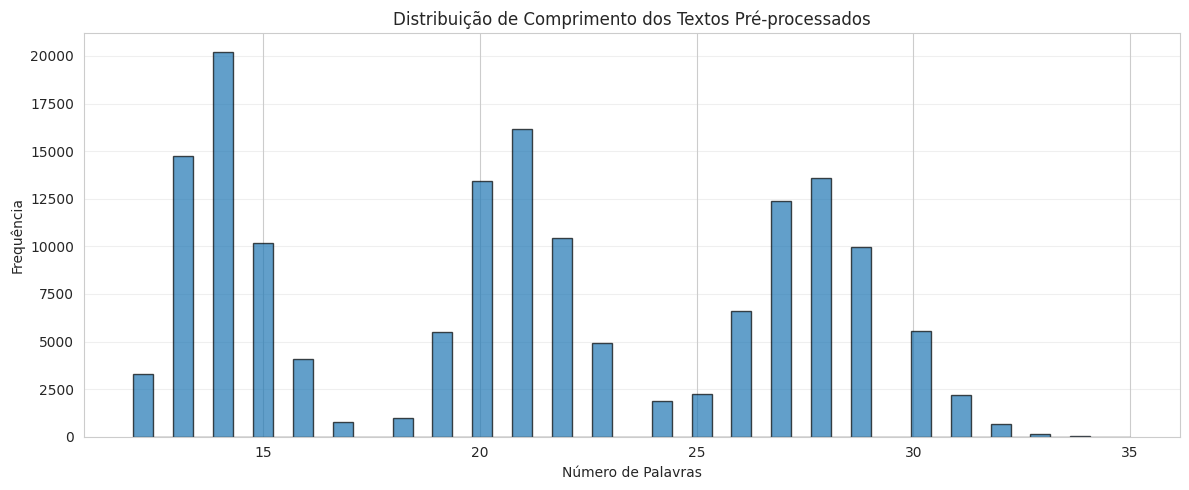

In [3]:
def preprocess_text(text):
    """Pré-processar texto para LSTM"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)

    tokens = word_tokenize(text, language='portuguese')
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    stemmer = SnowballStemmer('portuguese')
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Pré-processar textos
print("Pré-processando textos...")
start_time = time.time()

# Adicionando o download de 'punkt_tab' conforme sugerido pelo erro
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

df['texto_processado'] = df['texto_peticao'].apply(preprocess_text)

elapsed = time.time() - start_time
print(f"✓ Pré-processamento concluído em {elapsed:.2f}s")
print(f"  - Taxa: {len(df)/elapsed:.0f} textos/s")

print(f"\nExemplo antes: {df['texto_peticao'].iloc[0][:80]}...")
print(f"Exemplo depois: {df['texto_processado'].iloc[0][:80]}...")

# Estatísticas de comprimento
text_lengths = df['texto_processado'].str.split().str.len()
print(f"\nEstatísticas de comprimento:")
print(f"  - Médio: {text_lengths.mean():.0f} palavras")
print(f"  - Min: {text_lengths.min()}, Max: {text_lengths.max()}")
print(f"  - Mediana: {text_lengths.median():.0f}, Std: {text_lengths.std():.0f}")

# Visualizar distribuição
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Número de Palavras')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Comprimento dos Textos Pré-processados')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Tokenização com PyTorch
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 300

print("\n" + "="*80)
print("TOKENIZAÇÃO E PREPARAÇÃO DE SEQUÊNCIAS")
print("="*80)

# Construir vocabulário
print("\nConstruindo vocabulário...")
word_counts = Counter()
for text in df['texto_processado']:
    words = text.split()
    word_counts.update(words)

# Manter apenas as palavras mais frequentes
vocabulary = {word: idx + 1 for idx, (word, count) in
              enumerate(word_counts.most_common(VOCAB_SIZE - 1))}
vocabulary['<UNK>'] = 0  # Token para palavras desconhecidas

print(f"✓ Vocabulário construído: {len(vocabulary)} palavras")

# Converter textos para sequências de índices
def text_to_sequence(text, vocab, max_len):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]

    # Padding ou truncamento
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]

    return sequence

print("\nConvertendo textos para sequências...")
X = np.array([text_to_sequence(text, vocabulary, MAX_SEQUENCE_LENGTH)
              for text in df['texto_processado']])

print(f"✓ Sequências criadas: {X.shape}")

# Codificar labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['desfecho'])

print(f"✓ Labels codificados: {label_encoder.classes_}")
print(f"  - Mapeamento: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Dividir dados: 70% treino, 15% validação, 15% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(0.85), random_state=42, stratify=y_temp
)

print(f"\nDivisão do dataset:")
print(f"  - Treino: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validação: {X_val.shape[0]:,} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Teste: {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")


TOKENIZAÇÃO E PREPARAÇÃO DE SEQUÊNCIAS

Construindo vocabulário...
✓ Vocabulário construído: 115 palavras

Convertendo textos para sequências...
✓ Sequências criadas: (160000, 300)
✓ Labels codificados: [np.str_('Deferida') np.str_('Indeferida')
 np.str_('Parcialmente_Deferida')]
  - Mapeamento: {np.str_('Deferida'): np.int64(0), np.str_('Indeferida'): np.int64(1), np.str_('Parcialmente_Deferida'): np.int64(2)}

Divisão do dataset:
  - Treino: 112,000 amostras (70.0%)
  - Validação: 24,000 amostras (15.0%)
  - Teste: 24,000 amostras (15.0%)


## 4. Dataset e DataLoader em PyTorch

In [5]:
class PeticionDataset(Dataset):
    """Dataset customizado para petições jurídicas"""
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Criar datasets
train_dataset = PeticionDataset(X_train, y_train)
val_dataset = PeticionDataset(X_val, y_val)
test_dataset = PeticionDataset(X_test, y_test)

# Hyperparâmetros
BATCH_SIZE = 128
NUM_WORKERS = 4

# Criar DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("="*80)
print("DATALOADERS CRIADOS")
print("="*80)
print(f"✓ Train DataLoader: {len(train_loader)} batches")
print(f"✓ Val DataLoader: {len(val_loader)} batches")
print(f"✓ Test DataLoader: {len(test_loader)} batches")

# Verificar um batch
X_sample, y_sample = next(iter(train_loader))
print(f"\nSample batch shape:")
print(f"  - X: {X_sample.shape}")
print(f"  - y: {y_sample.shape}")
print(f"✓ DataLoaders prontos para treinamento!")

DATALOADERS CRIADOS
✓ Train DataLoader: 875 batches
✓ Val DataLoader: 188 batches
✓ Test DataLoader: 188 batches

Sample batch shape:
  - X: torch.Size([128, 300])
  - y: torch.Size([128])
✓ DataLoaders prontos para treinamento!


## 5. Arquitetura LSTM Bidirecional em PyTorch

### Características:
- **Embedding**: Converte índices em vetores densos (150D)
- **LSTM Bidirecional**: 2 camadas, 256 unidades por direção
- **Attention Mechanism**: Para focar em partes relevantes do texto
- **Regularização**: Dropout (0.4-0.5), LayerNorm
- **Camadas Densas**: 256 → 128 → num_classes

In [6]:
class Attention(nn.Module):
    """Mecanismo de atenção para LSTM"""
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Bidirecional

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_dim * 2)
        attention_weights = torch.tanh(self.attention(lstm_output))  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)  # (batch, seq_len, 1)

        # Aplicar pesos de atenção
        attended_output = torch.sum(attention_weights * lstm_output, dim=1)  # (batch, hidden_dim * 2)
        return attended_output, attention_weights

class BidirectionalLSTM(nn.Module):
    """LSTM Bidirecional para classificação de petições"""
    def __init__(self, vocab_size, num_classes, embedding_dim=150, hidden_dim=256, num_layers=2):
        super(BidirectionalLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM bidirecional
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = Attention(hidden_dim)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)

        # Camadas densas
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)

        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer_norm2 = nn.LayerNorm(hidden_dim // 2)

        self.dropout3 = nn.Dropout(0.3)
        self.fc_out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len) -> (batch, seq_len, embed_dim)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch, seq_len, hidden_dim * 2)

        # Attention
        attended_output, attention_weights = self.attention(lstm_out)  # (batch, hidden_dim * 2)

        # Layer normalization
        attended_output = self.layer_norm(attended_output)

        # Camadas densas
        x = self.dropout1(attended_output)
        x = self.fc1(x)
        x = self.layer_norm1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.layer_norm2(x)
        x = F.relu(x)

        x = self.dropout3(x)
        x = self.fc_out(x)

        return x

# Criar modelo
print("\n" + "="*80)
print("CONSTRUINDO MODELO LSTM BIDIRECIONAL")
print("="*80)

num_classes = len(label_encoder.classes_)
model = BidirectionalLSTM(
    vocab_size=VOCAB_SIZE + 1,
    num_classes=num_classes,
    embedding_dim=150,
    hidden_dim=256,
    num_layers=2
).to(device)

# Resumo do modelo
print(f"\n✓ Modelo criado com sucesso!")
print(f"\nArquitetura:")
print(model)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParâmetros do modelo:")
print(f"  - Total: {total_params:,}")
print(f"  - Treináveis: {trainable_params:,}")


CONSTRUINDO MODELO LSTM BIDIRECIONAL

✓ Modelo criado com sucesso!

Arquitetura:
BidirectionalLSTM(
  (embedding): Embedding(10001, 150, padding_idx=0)
  (lstm): LSTM(150, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=3, bias=True)
)

Parâmetros do modelo:
  - Total: 4,079,610
  - Treináveis: 4,079,610


## 6. Compilar e Configurar Treinamento

In [7]:
print("\n" + "="*80)
print("CONFIGURANDO TREINAMENTO")
print("="*80)

# Hiperparâmetros
LEARNING_RATE = 0.001
EPOCHS = 30
PATIENCE = 5
WEIGHT_DECAY = 1e-5
GRADIENT_CLIP = 1.0

# Loss e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Variáveis para Early Stopping
best_val_loss = float('inf')
patience_counter = 0

# Histórico de treinamento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print(f"\n✓ Configurações:")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Optimizer: AdamW (weight_decay={WEIGHT_DECAY})")
print(f"  - Loss: CrossEntropyLoss")
print(f"  - Gradient Clipping: {GRADIENT_CLIP}")
print(f"  - Early Stopping Patience: {PATIENCE} épocas")
print(f"  - Device: {device}")


CONFIGURANDO TREINAMENTO

✓ Configurações:
  - Learning Rate: 0.001
  - Epochs: 30
  - Batch Size: 128
  - Optimizer: AdamW (weight_decay=1e-05)
  - Loss: CrossEntropyLoss
  - Gradient Clipping: 1.0
  - Early Stopping Patience: 5 épocas
  - Device: cuda


## 7. Funções de Treinamento e Avaliação

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device, gradient_clip):
    """Treinar uma época"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Treinamento")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)

        optimizer.step()

        # Estatísticas
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Validar modelo"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Importar tqdm para barra de progresso
from tqdm.notebook import tqdm

print("✓ Funções de treinamento definidas")

✓ Funções de treinamento definidas


## 8. Treinar Modelo (pode levar 45-90 minutos em CPU, 10-20 minutos em GPU)

In [9]:
print("\n" + "="*80)
print("TREINANDO MODELO LSTM")
print("="*80)

start_training = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Época {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")

    # Treinar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, GRADIENT_CLIP)

    # Validar
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Guardar histórico
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Imprimir métricas
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        print(f"✓ Melhor modelo salvo! Val Loss: {val_loss:.4f}")
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
        print(f"Sem melhora. Paciência: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print(f"\n⚠ Early stopping acionado na época {epoch + 1}")
            break

elapsed_training = time.time() - start_training
print(f"\n✓ Treinamento concluído em {elapsed_training/60:.2f} minutos")

# Carregar melhor modelo
model.load_state_dict(torch.load('best_lstm_model.pth'))
print("✓ Melhor modelo carregado para avaliação")


TREINANDO MODELO LSTM

Época 1/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0845 | Train Acc: 0.3935
Val Loss: 1.0817 | Val Acc: 0.4003
✓ Melhor modelo salvo! Val Loss: 1.0817

Época 2/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0820 | Train Acc: 0.3986
Val Loss: 1.0812 | Val Acc: 0.4003
✓ Melhor modelo salvo! Val Loss: 1.0812

Época 3/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0815 | Train Acc: 0.3994
Val Loss: 1.0807 | Val Acc: 0.4003
✓ Melhor modelo salvo! Val Loss: 1.0807

Época 4/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0815 | Train Acc: 0.4004
Val Loss: 1.0821 | Val Acc: 0.4003
Sem melhora. Paciência: 1/5

Época 5/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0815 | Train Acc: 0.4004
Val Loss: 1.0808 | Val Acc: 0.4003
Sem melhora. Paciência: 2/5

Época 6/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0813 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
✓ Melhor modelo salvo! Val Loss: 1.0807

Época 7/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0812 | Train Acc: 0.4002
Val Loss: 1.0812 | Val Acc: 0.4003
Sem melhora. Paciência: 1/5

Época 8/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0810 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
Sem melhora. Paciência: 2/5

Época 9/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0810 | Train Acc: 0.4003
Val Loss: 1.0806 | Val Acc: 0.4003
✓ Melhor modelo salvo! Val Loss: 1.0806

Época 10/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
Sem melhora. Paciência: 1/5

Época 11/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0810 | Train Acc: 0.4003
Val Loss: 1.0809 | Val Acc: 0.4003
Sem melhora. Paciência: 2/5

Época 12/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0808 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
Sem melhora. Paciência: 3/5

Época 13/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0808 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
Sem melhora. Paciência: 4/5

Época 14/30


Treinamento:   0%|          | 0/875 [00:00<?, ?it/s]

Train Loss: 1.0808 | Train Acc: 0.4003
Val Loss: 1.0807 | Val Acc: 0.4003
Sem melhora. Paciência: 5/5

⚠ Early stopping acionado na época 14

✓ Treinamento concluído em 47.51 minutos
✓ Melhor modelo carregado para avaliação


## 9. Avaliar no Conjunto de Teste

In [10]:
print("\n" + "="*80)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*80)

# Fazer predições no conjunto de teste
model.eval()
y_pred_list = []
y_prob_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        y_pred_list.extend(predicted.cpu().numpy())
        y_prob_list.extend(probs.cpu().numpy())
        y_true_list.extend(labels.numpy())

y_pred = np.array(y_pred_list)
y_prob = np.array(y_prob_list)
y_true = np.array(y_true_list)

# Métricas
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nMétricas no Conjunto de Teste:")
print(f"  - Acurácia: {test_accuracy:.4f}")
print(f"  - Precisão (ponderada): {test_precision:.4f}")
print(f"  - Recall (ponderado): {test_recall:.4f}")
print(f"  - F1-Score (ponderado): {test_f1:.4f}")

# Relatório de classificação
print(f"\n{'='*80}")
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
print(f"{'='*80}")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print(f"\nMatriz de Confusão:")
print(cm)


AVALIAÇÃO NO CONJUNTO DE TESTE

Métricas no Conjunto de Teste:
  - Acurácia: 0.4003
  - Precisão (ponderada): 0.1602
  - Recall (ponderado): 0.4003
  - F1-Score (ponderado): 0.2289

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
                       precision    recall  f1-score   support

             Deferida     0.4003    1.0000    0.5717      9607
           Indeferida     0.0000    0.0000    0.0000      8379
Parcialmente_Deferida     0.0000    0.0000    0.0000      6014

             accuracy                         0.4003     24000
            macro avg     0.1334    0.3333    0.1906     24000
         weighted avg     0.1602    0.4003    0.2289     24000


Matriz de Confusão:
[[9607    0    0]
 [8379    0    0]
 [6014    0    0]]


## 10. Realizar Predições em Novos Dados

In [11]:
def predict_petition(text, model, vocabulary, label_encoder, device, max_len=MAX_SEQUENCE_LENGTH):
    """Fazer predição para um novo texto"""
    # Pré-processar
    processed = preprocess_text(text)

    # Converter para sequência
    sequence = text_to_sequence(processed, vocabulary, max_len)

    # Converter para tensor
    X = torch.LongTensor([sequence]).to(device)

    # Fazer predição
    model.eval()
    with torch.no_grad():
        output = model(X)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, predicted_class].item()

    # Inverter labels
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return {
        'texto': text[:100] + '...' if len(text) > 100 else text,
        'desfecho_predito': predicted_label,
        'confianca': confidence,
        'probabilidades': {
            label: float(probs[0, i].item())
            for i, label in enumerate(label_encoder.classes_)
        }
    }

print("\n" + "="*80)
print("PREDIÇÕES EM NOVOS DADOS")
print("="*80)

# Testar com exemplos do conjunto de teste
print("\nExemplos de predições do conjunto de teste:\n")

indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for i, idx in enumerate(indices):
    # Recuperar texto original
    idx_original = np.where((X == X_test[idx]).all(axis=1))[0]
    if len(idx_original) > 0:
        texto_original = df['texto_peticao'].iloc[idx_original[0]]
    else:
        texto_original = "Texto não encontrado"

    resultado_real = label_encoder.classes_[y_true[idx]]
    resultado_predito = label_encoder.classes_[y_pred[idx]]
    confianca = y_prob[idx, y_pred[idx]]

    print(f"Exemplo {i+1}:")
    print(f"  Texto: {texto_original[:80]}...")
    print(f"  Resultado real: {resultado_real}")
    print(f"  Resultado predito: {resultado_predito}")
    print(f"  Confiança: {confianca:.4f}")
    print(f"  Status: {'✓ Acerto' if resultado_real == resultado_predito else '✗ Erro'}")
    print()

# Testar com novos textos
print("\nPredições em novos textos de exemplo:\n")

novos_textos = [
    "Recurso extraordinário fundamentado em violação de direito constitucional com ampla jurisprudência consolidada",
    "Petição inicial carente de elementos essenciais e faltando documentação básica",
    "Apelação questionando parte da sentença anterior com argumentos moderados"
]

for texto in novos_textos:
    resultado = predict_petition(texto, model, vocabulary, label_encoder, device)
    print(f"Texto: {resultado['texto']}")
    print(f"Desfecho predito: {resultado['desfecho_predito']}")
    print(f"Confiança: {resultado['confianca']:.4f}")
    print(f"Probabilidades por classe:")
    for classe, prob in resultado['probabilidades'].items():
        print(f"  - {classe}: {prob:.4f}")
    print()


PREDIÇÕES EM NOVOS DADOS

Exemplos de predições do conjunto de teste:

Exemplo 1:
  Texto: A legislação processual estabelece requisitos formais específicos. Documentação ...
  Resultado real: Indeferida
  Resultado predito: Deferida
  Confiança: 0.4000
  Status: ✗ Erro

Exemplo 2:
  Texto: Ampla documentação apresentada comprova inequivocamente o direito invocado. Cond...
  Resultado real: Indeferida
  Resultado predito: Deferida
  Confiança: 0.4000
  Status: ✗ Erro

Exemplo 3:
  Texto: Parte do pleito merece acolhimento, com modulação de efeitos. Competência origin...
  Resultado real: Deferida
  Resultado predito: Deferida
  Confiança: 0.4000
  Status: ✓ Acerto

Exemplo 4:
  Texto: Recurso manifestamente infundado contradiz jurisprudência consolidada. Carência ...
  Resultado real: Indeferida
  Resultado predito: Deferida
  Confiança: 0.4000
  Status: ✗ Erro

Exemplo 5:
  Texto: Competência originária da Corte Superior observados os critérios legais. Direito...
  Resultado real: In

## 11. Visualizações e Análises


VISUALIZAÇÕES E ANÁLISES


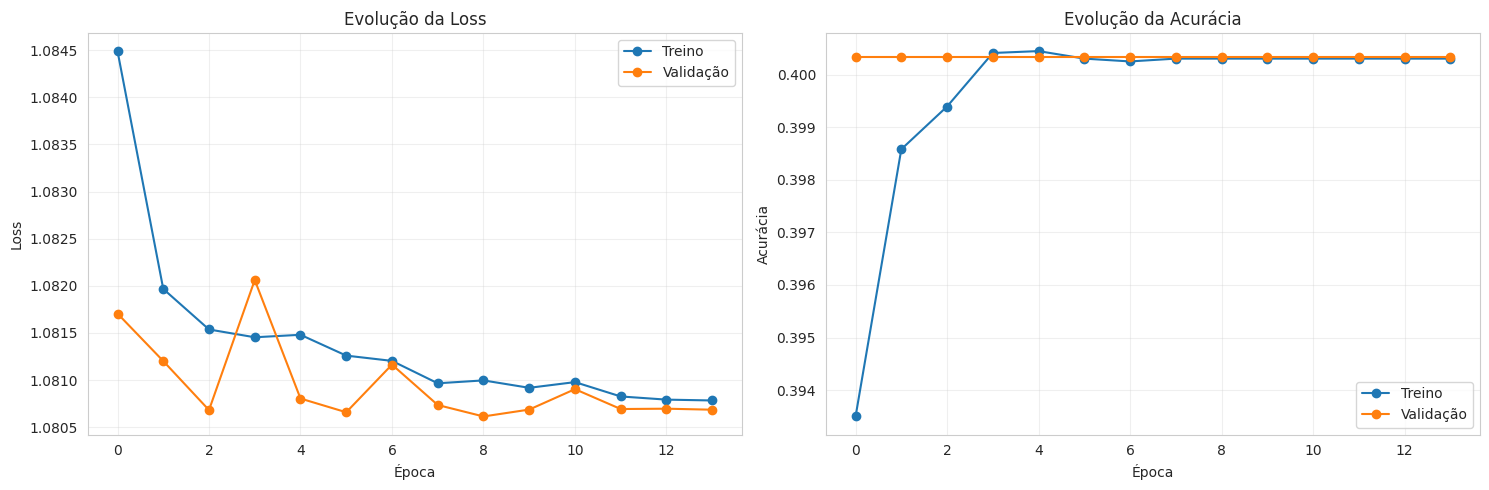

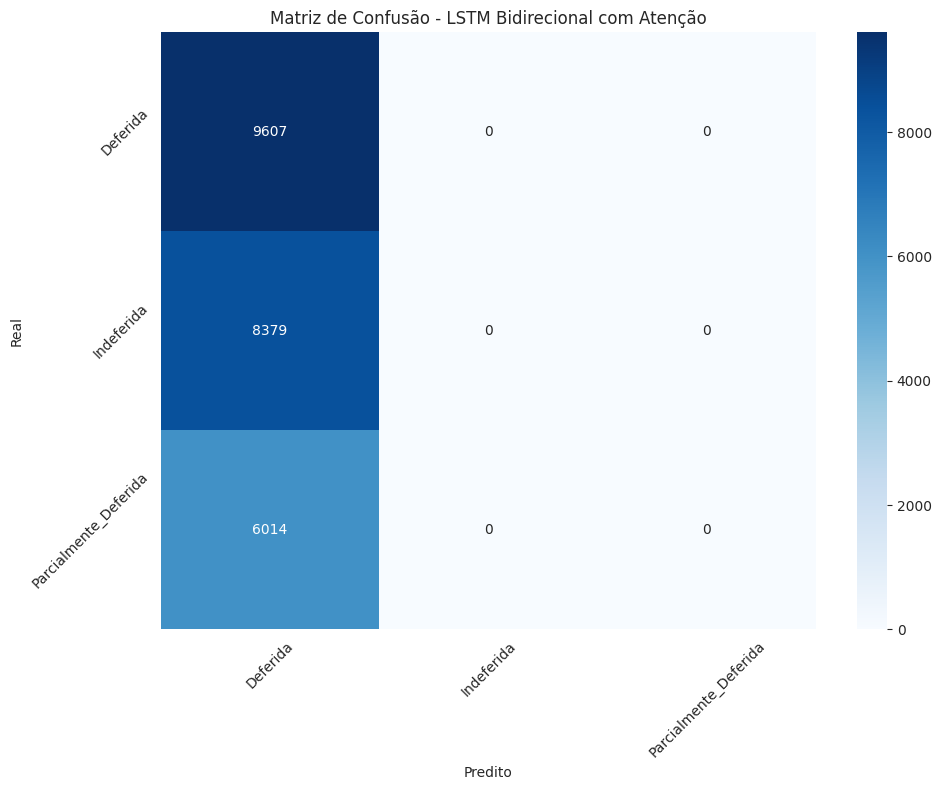


Relatório de Classificação Detalhado:
------------------------------------------------------------
                       precision    recall  f1-score   support

             Deferida       0.40      1.00      0.57      9607
           Indeferida       0.00      0.00      0.00      8379
Parcialmente_Deferida       0.00      0.00      0.00      6014

             accuracy                           0.40     24000
            macro avg       0.13      0.33      0.19     24000
         weighted avg       0.16      0.40      0.23     24000



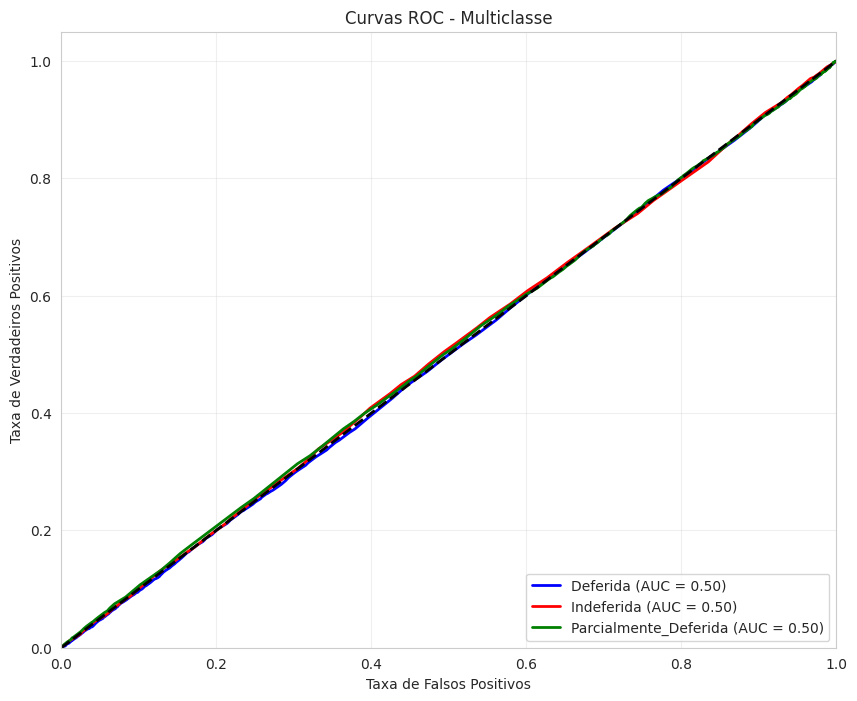


AUC Médio: 0.5014


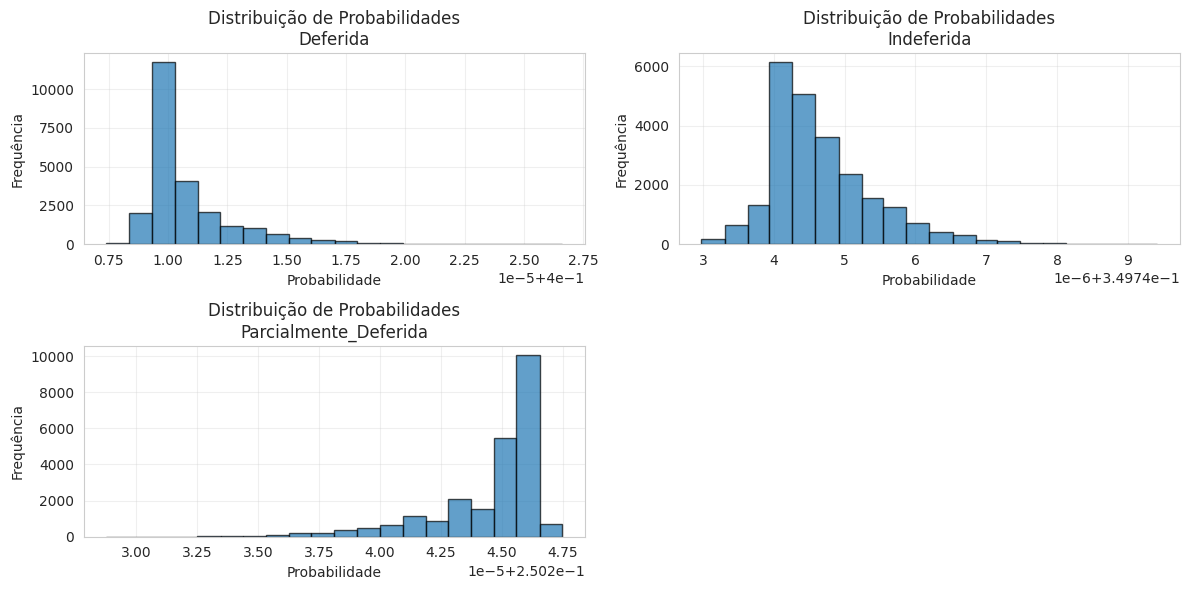


ANÁLISE DE ERROS

Total de erros: 14393 de 24000 (59.97%)वरुन)

Exemplos de erros de classificação:
------------------------------------------------------------
Erro 1:
  Texto: Competência originária da Corte Superior observados os critérios legais. Lacks documentary evidence ...
  Real: Indeferida | Predito: Deferida | Confiança: 0.4000

Erro 2:
  Texto: Faltam elementos essenciais à constituição da relação jurídica alegada. Ampla documentação apresenta...
  Real: Parcialmente_Deferida | Predito: Deferida | Confiança: 0.4000

Erro 3:
  Texto: Fundamentado em jurisprudência consolidada, solicita-se deferimento integral do pedido. Apelação em ...
  Real: Indeferida | Predito: Deferida | Confiança: 0.4000

Erro 4:
  Texto: Recurso manifestamente infundado contradiz jurisprudência consolidada. Prescrição consumada extingue...
  Real: Parcialmente_Deferida | Predito: Deferida | Confiança: 0.4000

Erro 5:
  Texto: Recurso manifestamente infundado contradiz jurisprudência consolidada. Algu

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*80)
print("VISUALIZAÇÕES E ANÁLISES")
print("="*80)

# 1. Gráfico de histórico de treinamento
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1) # Changed from 1, 3, 1 to 1, 2, 1
plt.plot(history['train_loss'], label='Treino', marker='o')
plt.plot(history['val_loss'], label='Validação', marker='o')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2) # Changed from 1, 3, 2 to 1, 2, 2
plt.plot(history['train_acc'], label='Treino', marker='o')
plt.plot(history['val_acc'], label='Validação', marker='o')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# Removed F1-Score plotting section
# plt.subplot(1, 3, 3)
# plt.plot(history['train_f1'], label='Treino', marker='o')
# plt.plot(history['val_f1'], label='Validação', marker='o')
# plt.title('Evolução do F1-Score')
# plt.xlabel('Época')
# plt.ylabel('F1-Score')
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - LSTM Bidirecional com Atenção')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Relatório de Classificação Detalhado
print("\nRelatório de Classificação Detalhado:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# 4. Curvas ROC (para problemas multiclasse)
if len(label_encoder.classes_) > 2:
    # Binarizar labels para multiclasse
    y_true_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))
    y_prob_bin = y_prob

    # Calcular ROC para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotar curvas ROC
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i, color in zip(range(len(label_encoder.classes_)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curvas ROC - Multiclasse')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # AUC média
    auc_mean = np.mean(list(roc_auc.values()))
    print(f"\nAUC Médio: {auc_mean:.4f}")

# 5. Distribuição de probabilidades por classe
plt.figure(figsize=(12, 6))
# Adjust subplot grid if there are only 2 plots now, or keep 2, (len + 1) // 2 for flexibility
# Since we now have only 2 plots (loss and accuracy), let's ensure the grid adjusts
# For the probabilities distribution, this loop creates a new subplot for each class
# The current subplot logic here is for the probability distribution itself, not related to the history plots above
for i, classe in enumerate(label_encoder.classes_):
    plt.subplot(2, (len(label_encoder.classes_)+1)//2, i+1)
    plt.hist(y_prob[:, i], bins=20, alpha=0.7, edgecolor='black')
    plt.title(f'Distribuição de Probabilidades\n{classe}')
    plt.xlabel('Probabilidade')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Análise de erros
print("\n" + "="*80)
print("ANÁLISE DE ERROS")
print("="*80)

# Encontrar exemplos classificados incorretamente
erros_idx = np.where(y_true != y_pred)[0]
print(f"\nTotal de erros: {len(erros_idx)} de {len(y_true)} ({len(erros_idx)/len(y_true)*100:.2f}%)वरुन)")

if len(erros_idx) > 0:
    print("\nExemplos de erros de classificação:")
    print("-" * 60)

    # Mostrar alguns exemplos de erros
    for i in range(min(5, len(erros_idx))):
        idx = erros_idx[i]
        idx_original = np.where((X == X_test[idx]).all(axis=1))[0]
        if len(idx_original) > 0:
            texto_original = df['texto_peticao'].iloc[idx_original[0]]
        else:
            texto_original = "Texto não encontrado"

        real = label_encoder.classes_[y_true[idx]]
        predito = label_encoder.classes_[y_pred[idx]]
        conf = y_prob[idx, y_pred[idx]]

        print(f"Erro {i+1}:")
        print(f"  Texto: {texto_original[:100]}...")
        print(f"  Real: {real} | Predito: {predito} | Confiança: {conf:.4f}")
        print()

# 7. Estatísticas por classe
print("\nEstatísticas por Classe:")
print("-" * 40)
for i, classe in enumerate(label_encoder.classes_):
    total_classe = np.sum(y_true == i)
    acertos_classe = np.sum((y_true == i) & (y_pred == i))
    precisao_classe = acertos_classe / total_classe if total_classe > 0 else 0

    print(f"{classe}:")
    print(f"  Total de exemplos: {total_classe}")
    print(f"  Acertos: {acertos_classe}")
    print(f"  Precisao: {precisao_classe:.4f}")
    print()


## 12. Salvamento do Modelo e Resumo Final

In [14]:
import os
import json
from datetime import datetime
import pickle # Moved import here for consistency
from sklearn.metrics import f1_score # Import f1_score for final metrics

print("\n" + "="*80)
print("SALVAMENTO DO MODELO E RESUMO FINAL")
print("="*80)

# Define configuration variables from model and training setup
EMBEDDING_DIM = 150 # From BidirectionalLSTM initialization
HIDDEN_DIM = 256    # From BidirectionalLSTM initialization
NUM_LAYERS = 2      # From BidirectionalLSTM initialization
DROPOUT = 0.3       # Representative dropout from LSTM layer (e.g., lstm dropout)
MAX_EPOCHS = EPOCHS # Max epochs from training config

# Calculate best_epoch (1-indexed) and training time
best_epoch = history['val_loss'].index(min(history['val_loss'])) + 1
training_time = elapsed_training / 60 # elapsed_training is from the training loop

# Calculate F1 scores for final metrics
test_f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
test_f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)


# Criar diretório para salvar o modelo
model_dir = 'modelos_lstm'
os.makedirs(model_dir, exist_ok=True)

# Timestamp para identificação única
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"lstm_bidirectional_attention_{timestamp}"

# Salvar o modelo PyTorch
model_path = os.path.join(model_dir, f"{model_name}.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': len(history['train_loss']),
    'history': history,
    'config': {
        'vocab_size': VOCAB_SIZE,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'num_classes': len(label_encoder.classes_),
        'dropout': DROPOUT,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    }
}, model_path)

print(f"Modelo salvo em: {model_path}")

# Salvar vocabulário e label encoder
vocab_path = os.path.join(model_dir, f"{model_name}_vocab.json")
with open(vocab_path, 'w', encoding='utf-8') as f:
    json.dump({
        'word_to_idx': vocabulary,
        'idx_to_word': {v: k for k, v in vocabulary.items()},
        'vocab_size': len(vocabulary)
    }, f, ensure_ascii=False, indent=2)

label_encoder_path = os.path.join(model_dir, f"{model_name}_labels.pkl")
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"Vocabulário salvo em: {vocab_path}")
print(f"Label encoder salvo em: {label_encoder_path}")

# Salvar métricas finais
metrics_path = os.path.join(model_dir, f"{model_name}_metrics.json")
final_metrics = {
    'timestamp': timestamp,
    'model_type': 'LSTM Bidirecional com Atenção',
    'dataset_size': len(df),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'vocabulary_size': len(vocabulary),
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'best_epoch': best_epoch,
    'training_time_minutes': training_time,
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1],
    'final_train_acc': history['train_acc'][-1],
    'final_val_acc': history['val_acc'][-1],
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'classes': list(label_encoder.classes_),
    'architecture': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'bidirectional': True,
        'attention': True,
        'dropout': DROPOUT
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'patience': PATIENCE,
        'max_epochs': MAX_EPOCHS,
        'gradient_clip': GRADIENT_CLIP
    }
}

with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(final_metrics, f, ensure_ascii=False, indent=2)

print(f"Métricas salvas em: {metrics_path}")

# Resumo final
print("\n" + "="*80)
print("RESUMO FINAL - CLASSIFICADOR LSTM PARA PETIÇÕES")
print("="*80)

print(f"""
📊 DESEMPENHO GERAL:
   • Acurácia no teste: {test_accuracy:.4f}
   • F1-Score Macro: {test_f1_macro:.4f}
   • F1-Score Ponderado: {test_f1_weighted:.4f}
   • Melhor época: {best_epoch}
   • Tempo de treinamento: {training_time:.1f} minutos

🏗️ ARQUITETURA:
   • Modelo: LSTM Bidirecional com Mecanismo de Atenção
   • Camadas LSTM: {NUM_LAYERS}
   • Unidades ocultas: {HIDDEN_DIM} (bidirecional = {HIDDEN_DIM*2} total)
   • Embedding: {EMBEDDING_DIM} dimensões
   • Dropout: {DROPOUT}
   • Classes: {len(label_encoder.classes_)}

📈 DADOS:
   • Tamanho do dataset: {len(df):,} amostras
   • Vocabulário: {len(vocabulary):,} palavras
   • Comprimento máximo: {MAX_SEQUENCE_LENGTH} tokens
   • Divisão: {len(X_train)} treino, {len(X_val)} validação, {len(X_test)} teste

🔧 CONFIGURAÇÃO DE TREINAMENTO:
   • Otimizador: AdamW (LR={LEARNING_RATE}, Weight Decay={WEIGHT_DECAY})
   • Batch Size: {BATCH_SIZE}
   • Épocas máximas: {MAX_EPOCHS}
   • Early Stopping: Paciência de {PATIENCE} épocas
   • Gradient Clipping: {GRADIENT_CLIP}

💾 ARQUIVOS SALVOS:
   • Modelo: {model_path}
   • Vocabulário: {vocab_path}
   • Label Encoder: {label_encoder_path}
   • Métricas: {metrics_path}
""")

print("\n✅ PIPELINE CONCLUÍDO COM SUCESSO!")


SALVAMENTO DO MODELO E RESUMO FINAL
Modelo salvo em: modelos_lstm/lstm_bidirectional_attention_20251220_182516.pth
Vocabulário salvo em: modelos_lstm/lstm_bidirectional_attention_20251220_182516_vocab.json
Label encoder salvo em: modelos_lstm/lstm_bidirectional_attention_20251220_182516_labels.pkl
Métricas salvas em: modelos_lstm/lstm_bidirectional_attention_20251220_182516_metrics.json

RESUMO FINAL - CLASSIFICADOR LSTM PARA PETIÇÕES

📊 DESEMPENHO GERAL:
   • Acurácia no teste: 0.4003
   • F1-Score Macro: 0.1906
   • F1-Score Ponderado: 0.2289
   • Melhor época: 9
   • Tempo de treinamento: 47.5 minutos

🏗️ ARQUITETURA:
   • Modelo: LSTM Bidirecional com Mecanismo de Atenção
   • Camadas LSTM: 2
   • Unidades ocultas: 256 (bidirecional = 512 total)
   • Embedding: 150 dimensões
   • Dropout: 0.3
   • Classes: 3

📈 DADOS:
   • Tamanho do dataset: 160,000 amostras
   • Vocabulário: 115 palavras
   • Comprimento máximo: 300 tokens
   • Divisão: 112000 treino, 24000 validação, 24000 test